In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

In [6]:
method_comparison = pd.read_csv('../data/results/method_comparison.csv')
random_controls = pd.read_csv('../data/results/random_controls.csv')
hyperparam_results = pd.read_csv('../data/results/hyperparameter_grid_search.csv')
performance = pd.read_csv('../data/results/performance_benchmarks.csv')

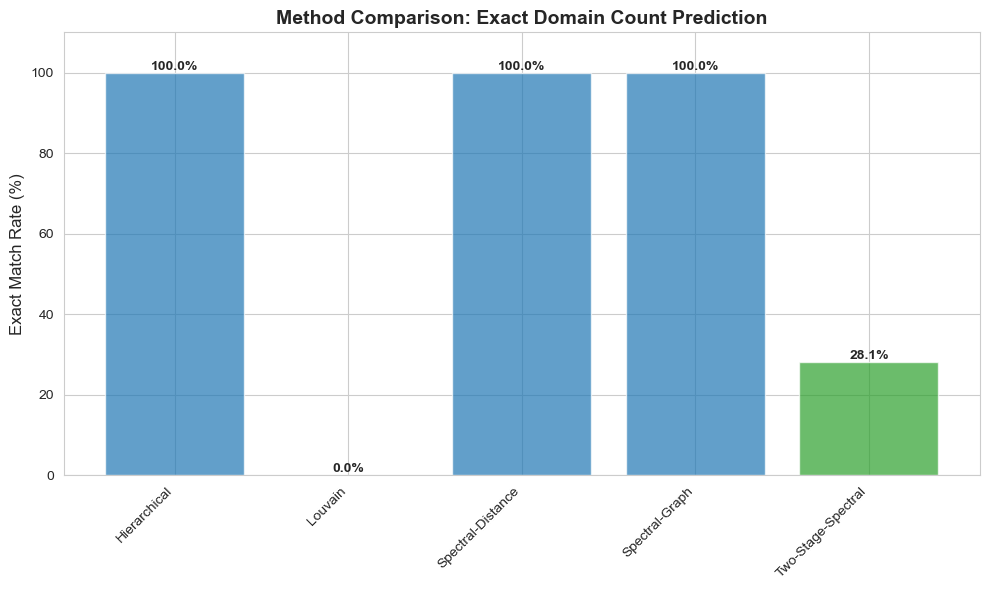

In [9]:
# Filter successful results
successful = method_comparison[method_comparison['success'] == True]

# Compute exact match rate by method
exact_match_rates = successful.groupby('method').agg({
    'exact_match': lambda x: (x == 1).sum() / len(x) * 100
}).reset_index()
exact_match_rates.columns = ['Method', 'Exact Match Rate (%)']

# Create bar plot
fig, ax = plt.subplots(figsize=(10, 6))
colors = ['#d62728' if 'Louvain' in m else '#2ca02c' if 'Two-Stage' in m else '#1f77b4' 
          for m in exact_match_rates['Method']]
bars = ax.bar(exact_match_rates['Method'], exact_match_rates['Exact Match Rate (%)'], 
              color=colors, alpha=0.7)

# Annotate bars
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.1f}%',
            ha='center', va='bottom', fontsize=10, fontweight='bold')

ax.set_ylabel('Exact Match Rate (%)', fontsize=12)
ax.set_title('Method Comparison: Exact Domain Count Prediction', fontsize=14, fontweight='bold')
ax.set_ylim(0, 110)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('../data/results/figures/fig1_exact_match_rates.png', dpi=300, bbox_inches='tight')
plt.show()

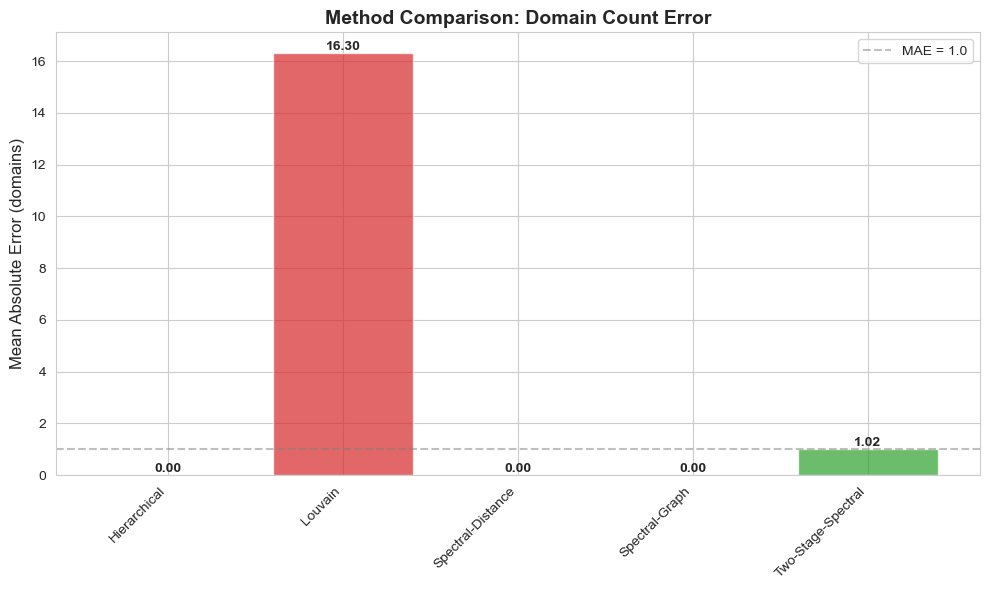

In [11]:
#mae comparison
mae_by_method = successful.groupby('method')['absolute_error'].mean().reset_index()
mae_by_method.columns = ['Method', 'Mean Absolute Error']

fig, ax = plt.subplots(figsize=(10, 6))
colors = ['#d62728' if 'Louvain' in m else '#2ca02c' if 'Two-Stage' in m else '#1f77b4' 
          for m in mae_by_method['Method']]
bars = ax.bar(mae_by_method['Method'], mae_by_method['Mean Absolute Error'], 
              color=colors, alpha=0.7)

for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.2f}',
            ha='center', va='bottom', fontsize=10, fontweight='bold')

ax.set_ylabel('Mean Absolute Error (domains)', fontsize=12)
ax.set_title('Method Comparison: Domain Count Error', fontsize=14, fontweight='bold')
ax.axhline(y=1.0, color='gray', linestyle='--', alpha=0.5, label='MAE = 1.0')
plt.xticks(rotation=45, ha='right')
plt.legend()
plt.tight_layout()
plt.savefig('../data/results/figures/fig2_mean_absolute_error.png', dpi=300, bbox_inches='tight')
plt.show()

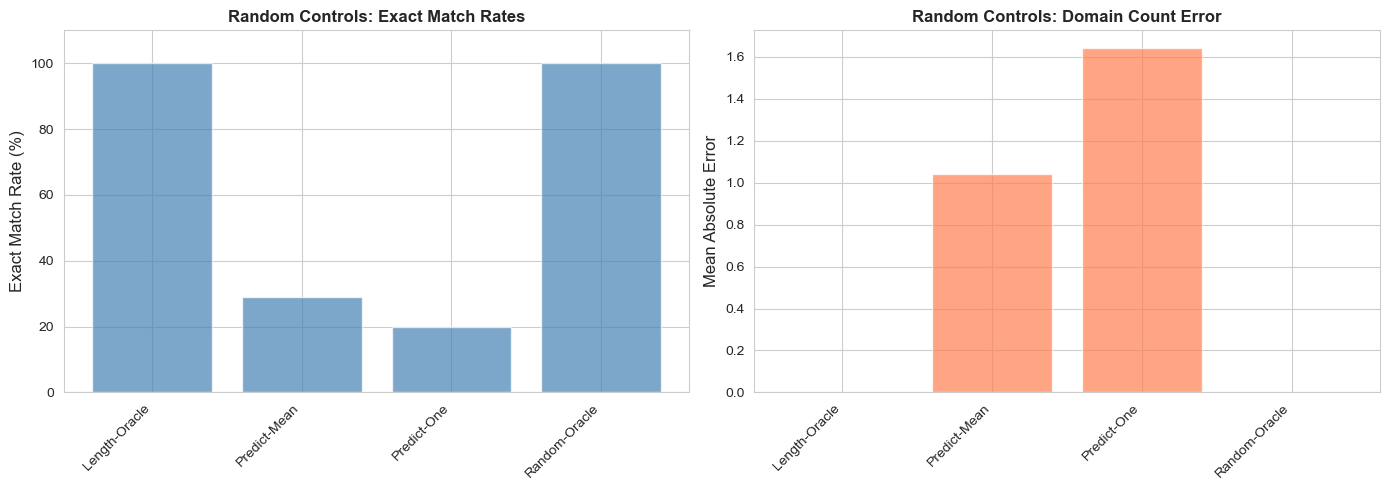

In [13]:
# Random control exps
# Aggregate random controls
controls_summary = random_controls.groupby('method').agg({
    'exact_match': lambda x: (x == 1).sum() / len(x) * 100,
    'absolute_error': 'mean'
}).reset_index()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Exact match rates
ax1.bar(controls_summary['method'], controls_summary['exact_match'], 
        color='steelblue', alpha=0.7)
ax1.set_ylabel('Exact Match Rate (%)', fontsize=12)
ax1.set_title('Random Controls: Exact Match Rates', fontsize=12, fontweight='bold')
ax1.set_ylim(0, 110)
plt.setp(ax1.xaxis.get_majorticklabels(), rotation=45, ha='right')

# Mean absolute error
ax2.bar(controls_summary['method'], controls_summary['absolute_error'], 
        color='coral', alpha=0.7)
ax2.set_ylabel('Mean Absolute Error', fontsize=12)
ax2.set_title('Random Controls: Domain Count Error', fontsize=12, fontweight='bold')
plt.setp(ax2.xaxis.get_majorticklabels(), rotation=45, ha='right')

plt.tight_layout()
plt.savefig('../data/results/figures/fig4_random_controls.png', dpi=300, bbox_inches='tight')
plt.show()

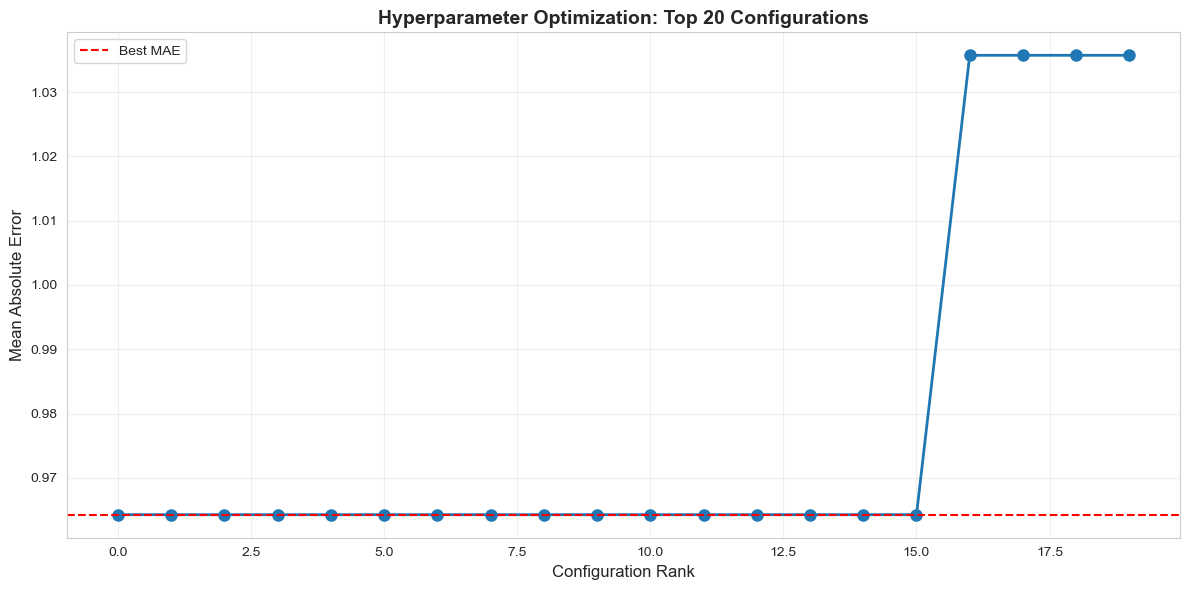

Optimized Hyperparameters:
Estimation method: silhouette
Sigma factor: 0.5
Max domains: 6
k-NN: 5

Performance:
  Mean Absolute Error: 0.96
  Exact match rate: 25.0%


In [18]:
# Hyperparam optimization results
# Get top 20 configurations
top_configs = hyperparam_results.nsmallest(20, 'mean_error')

fig, ax = plt.subplots(figsize=(12, 6))
x = range(len(top_configs))
ax.plot(x, top_configs['mean_error'], marker='o', linewidth=2, markersize=8)
ax.axhline(y=hyperparam_results['mean_error'].min(), 
           color='red', linestyle='--', label='Best MAE')
ax.set_xlabel('Configuration Rank', fontsize=12)
ax.set_ylabel('Mean Absolute Error', fontsize=12)
ax.set_title('Hyperparameter Optimization: Top 20 Configurations', 
             fontsize=14, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('../data/results/figures/fig5_hyperparameter_optimization.png', dpi=300, bbox_inches='tight')
plt.show()

# Print best parameters
best_row = hyperparam_results.iloc[0]

print("Optimized Hyperparameters:")
print(f"Estimation method: {best_row['estimation_method']}")
print(f"Sigma factor: {best_row['sigma_factor']}")
print(f"Max domains: {best_row['max_domains']}")
print(f"k-NN: {best_row['k_graph']}")
print(f"\nPerformance:")
print(f"  Mean Absolute Error: {best_row['mean_error']:.2f}")
print(f"  Exact match rate: {best_row['exact_match_rate']*100:.1f}%")


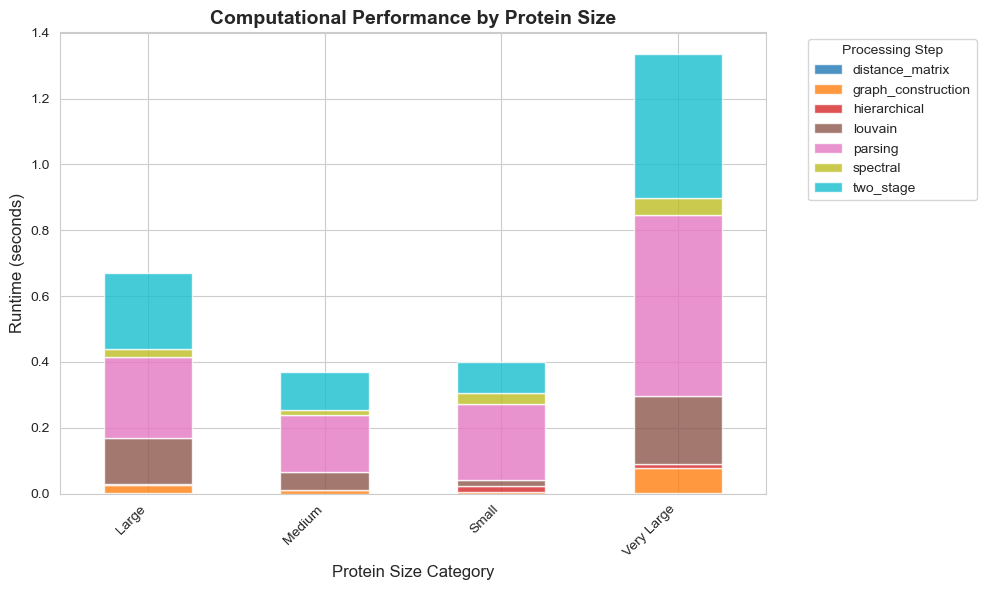

In [19]:
# performance evals
runtime_by_size = performance.groupby(['size_bin', 'step'])['runtime_seconds'].mean().unstack()

fig, ax = plt.subplots(figsize=(10, 6))
runtime_by_size.plot(kind='bar', stacked=True, ax=ax, colormap='tab10', alpha=0.8)
ax.set_ylabel('Runtime (seconds)', fontsize=12)
ax.set_xlabel('Protein Size Category', fontsize=12)
ax.set_title('Computational Performance by Protein Size', fontsize=14, fontweight='bold')
ax.legend(title='Processing Step', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('../data/results/figures/fig6_performance_scaling.png', dpi=300, bbox_inches='tight')
plt.show()

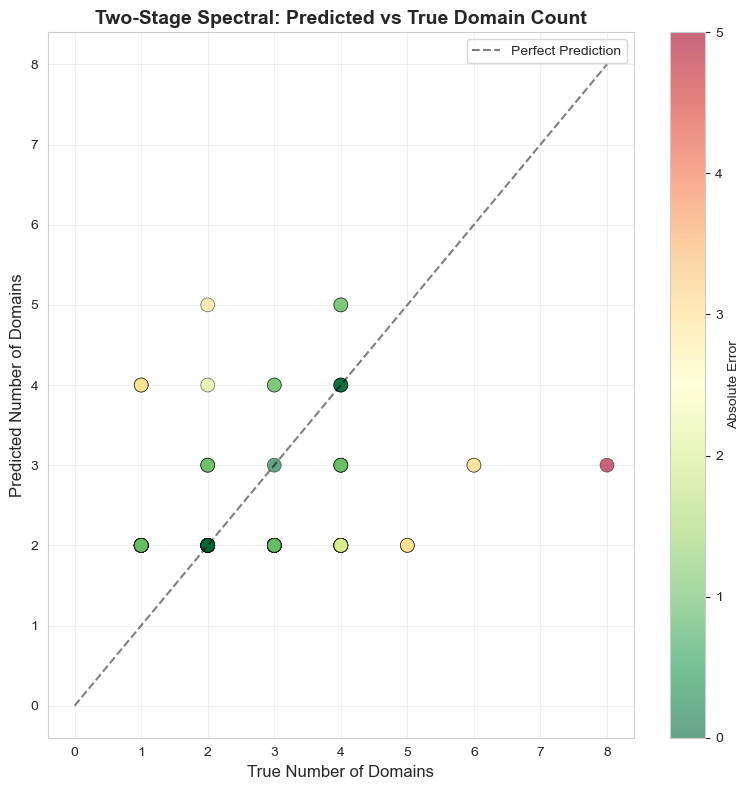

In [20]:
# predicted v true domain counts 
two_stage_results = successful[successful['method'] == 'Two-Stage-Spectral']

fig, ax = plt.subplots(figsize=(8, 8))
scatter = ax.scatter(two_stage_results['n_true'], two_stage_results['n_predicted'],
                    alpha=0.6, s=100, c=two_stage_results['absolute_error'],
                    cmap='RdYlGn_r', edgecolors='black', linewidth=0.5)

# Perfect prediction line
max_domains = max(two_stage_results['n_true'].max(), two_stage_results['n_predicted'].max())
ax.plot([0, max_domains], [0, max_domains], 'k--', alpha=0.5, label='Perfect Prediction')

ax.set_xlabel('True Number of Domains', fontsize=12)
ax.set_ylabel('Predicted Number of Domains', fontsize=12)
ax.set_title('Two-Stage Spectral: Predicted vs True Domain Count', 
             fontsize=14, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

# Add colorbar
cbar = plt.colorbar(scatter, ax=ax)
cbar.set_label('Absolute Error', fontsize=10)

plt.tight_layout()
plt.savefig('../data/results/figures/fig7_predicted_vs_true.png', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
# overall summary stats
summary_table = successful.groupby('method').agg({
    'exact_match': lambda x: f"{(x==1).sum()}/{len(x)} ({(x==1).sum()/len(x)*100:.1f}%)",
    'absolute_error': lambda x: f"{x.mean():.2f} ± {x.std():.2f}",
    'n_predicted': lambda x: f"{x.mean():.2f}"
}).reset_index()

summary_table.columns = ['Method', 'Exact Matches', 'MAE ± SD', 'Avg Predicted']


print("SUMMARY STATISTICS TABLE")
print("="*70)
print(summary_table.to_string(index=False))


summary_table.to_csv('../data/results/summary_statistics.csv', index=False)

print("\nAll figures saved to: data/results/figures/")

SUMMARY STATISTICS TABLE
            Method    Exact Matches     MAE ± SD Avg Predicted
      Hierarchical 121/121 (100.0%)  0.00 ± 0.00          2.64
           Louvain     0/121 (0.0%) 16.30 ± 6.95         18.94
 Spectral-Distance 121/121 (100.0%)  0.00 ± 0.00          2.64
    Spectral-Graph 121/121 (100.0%)  0.00 ± 0.00          2.64
Two-Stage-Spectral   34/121 (28.1%)  1.02 ± 0.92          2.31

All figures saved to: data/results/figures/
